In [1]:
"""
Author https://github.com/boguss1225
Reference : https://github.com/calmisential/TensorFlow2.0_Image_Classification
"""
from __future__ import absolute_import, division, print_function
import tensorflow as tf
import pandas as pd
import config
from utils.test_single_image import test_single_image
from utils.evaluate import eval_model
from utils.prepare_data import get_datasets
from utils.pretrained_models import pretrained_model
import matplotlib.pyplot as plt
import math
import config

2023-02-19 23:11:48.377311: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-19 23:11:49.357618: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib64
2023-02-19 23:11:49.357686: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib64
2023-02-19 23:11:49.357693: W tensorflow/c

In [2]:
# SELECT GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
# SELECT MODEL

available_models=["Xception",
                  "EfficientNetB0", "EfficientNetB1", "EfficientNetB2",
                  "EfficientNetB3", "EfficientNetB4", "EfficientNetB5",
                  "EfficientNetB6", "EfficientNetB7",
                  "EfficientNetV2B0", "EfficientNetV2B1",
                  "EfficientNetV2B2", "EfficientNetV2B3",
                  "EfficientNetV2S", "EfficientNetV2M", "EfficientNetV2L",
                  "VGG16","VGG19",
                  "DenseNet121", "DenseNet169", "DenseNet201",
                  "NASNetLarge","NASNetMobile",
                  "InceptionV3","InceptionResNetV2"
                  ]

def get_model():
    model = pretrained_model(model_name="EfficientNetV2B0",
                            load_weight=None)

    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
                  metrics=['accuracy', # add more metrics if you want
                            tf.keras.metrics.AUC(),
                            tf.keras.metrics.Precision(),
                            tf.keras.metrics.Recall(),
                            ])
    return model

In [4]:
# GPU settings
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
# LOAD DATA
train_generator, valid_generator, test_generator, \
train_num, valid_num, test_num = get_datasets()

Found 2694 images belonging to 2 classes.
Found 579 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


In [6]:
"""
Apply image data augmentation in 'utils.prepare_data.py' manually
"""

"\nApply image data augmentation in 'utils.prepare_data.py' manually\n"

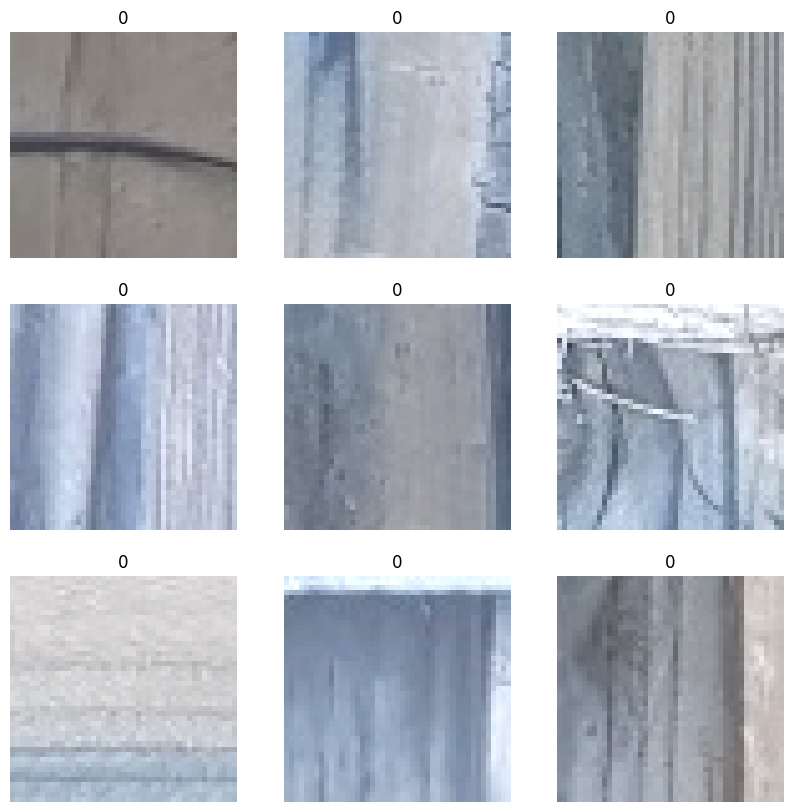

In [7]:
"""
## Visualize the data after augmentaion
Here are the first 9 images in the training dataset. 
Label 0 : "worm"
Label 1 : "vegetation-1"
"""
if config.BATCH_SIZE > 9 :
    range_val = 9
else :
    range_val = config.BATCH_SIZE

plt.figure(figsize=(10, 10))
for i in range(range_val):
    ax = plt.subplot(3, 3, i + 1)
    img, label = train_generator.next()
    plt.imshow(img[0].astype("uint8"))
    plt.title(label[0].argmax())
    plt.axis("off")

In [8]:
model = get_model()
# tf.keras.utils.plot_model(model, show_shapes=True)

2023-02-19 23:11:51.524072: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-19 23:11:52.016303: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43654 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:21:00.0, compute capability: 8.6


In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(45, 45, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
                  metrics=['accuracy', # add more metrics if you want
                            tf.keras.metrics.AUC(),
                            tf.keras.metrics.Precision(),
                            tf.keras.metrics.Recall(),
                            ])

In [10]:
# Print the final fiter number
conv_layers = [layer for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)]  # Get a list of all convolutional layers
final_conv_layer = conv_layers[-1]  # Get the final last convolutional layer from the list
num_filters = final_conv_layer.get_weights()[0].shape[-1]
print('Number of filters in final convolutional layer:', num_filters)

Number of filters in final convolutional layer: 128


In [11]:
from tensorflow.keras.callbacks import Callback

class FilterVisualizer(Callback):
    final_conv_layer
    num_filters
    
    def __init__(self):
        super(FilterVisualizer, self).__init__()
        conv_layers = [layer for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)]  # Get a list of all convolutional layers
        self.final_conv_layer = conv_layers[-1]  # Get the final convolutional layer from the list
        self.num_filters = self.final_conv_layer.get_weights()[0].shape[-1]
        print('Number of filters in final convolutional layer:', self.num_filters)
         # adjust num_filters for
        if self.num_filters > 25 : 
            self.num_filters = 25
        
    def on_epoch_end(self, epoch, logs=None):
        # Get the weights of the final convolutional layer
        try :
            filters, biases = self.final_conv_layer.get_weights()
        except :
            filters = self.final_conv_layer.get_weights()

        # Normalize the filter values
        f_min, f_max = filters.min(), filters.max()
        filters = (filters - f_min) / (f_max - f_min)

        # Calculate the number of rows and columns needed for the subplot grid
        num_cols = math.ceil(math.sqrt(self.num_filters))
        num_rows = math.ceil(self.num_filters / num_cols)

        # Create the subplot grid
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))
        fig.suptitle('Filters of the last Conv2d')

        # Plot each filter in a subplot
        for i in range(num_rows):
            for j in range(num_cols):
                # Calculate the filter index based on the current row and column
                filter_index = i * num_cols + j

                # If there are more filters to display, plot the current filter in a subplot
                if filter_index < self.num_filters:
                    # axs[i, j].imshow(filters[:, :, :, filter_index], cmap='gray')
                    axs[i, j].imshow(filters[:, :, :, filter_index].transpose((2,0,1)), cmap='gray')
                    axs[i, j].axis('off')
                else:
                    break

        # Display the subplot grid
        plt.show()
        


In [12]:
"""
Callbacks
"""

# tensorboard = tf.keras.callbacks.TensorBoard(log_dir='log')

filter_visualizer = FilterVisualizer()

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=config.model_dir+config.model_save_name+".keras",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    patience=50,
    restore_best_weights=True
)

callbacks = [
#     tensorboard, 
    filter_visualizer,
    model_checkpoint_callback, 
    early_stop_callback
]

Number of filters in final convolutional layer: 128


In [13]:
import os
from PIL import Image, UnidentifiedImageError
import io

# Set the path to your image directory
image_dir = config.valid_dir + "/bg"

# Loop over all image files in the directory
for file in os.listdir(image_dir):
    if file.endswith('.jpg') or file.endswith('.png'):
        # Load the image data from file
        with open(os.path.join(image_dir, file), 'rb') as f:
            image_data = f.read()

        # Store the image data in a BytesIO object
        buffer = io.BytesIO()
        buffer.write(image_data)

        # Attempt to open the image from the buffer
        try:
            image = Image.open(buffer)
        except UnidentifiedImageError:
            # Print the file path and the contents of the buffer
            buffer.seek(0)
            print('Error loading image:', os.path.join(image_dir, file))

Epoch 1/100


2023-02-19 23:11:55.451580: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700
2023-02-19 23:11:56.081144: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-19 23:11:56.084512: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f09d8022540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-19 23:11:56.084546: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2023-02-19 23:11:56.089569: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-19 23:11:56.208711: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


82/84 [============================>.] - ETA: 0s - loss: 23.1428 - accuracy: 0.4958 - auc_1: 0.5023 - precision_1: 0.4958 - recall_1: 0.4958

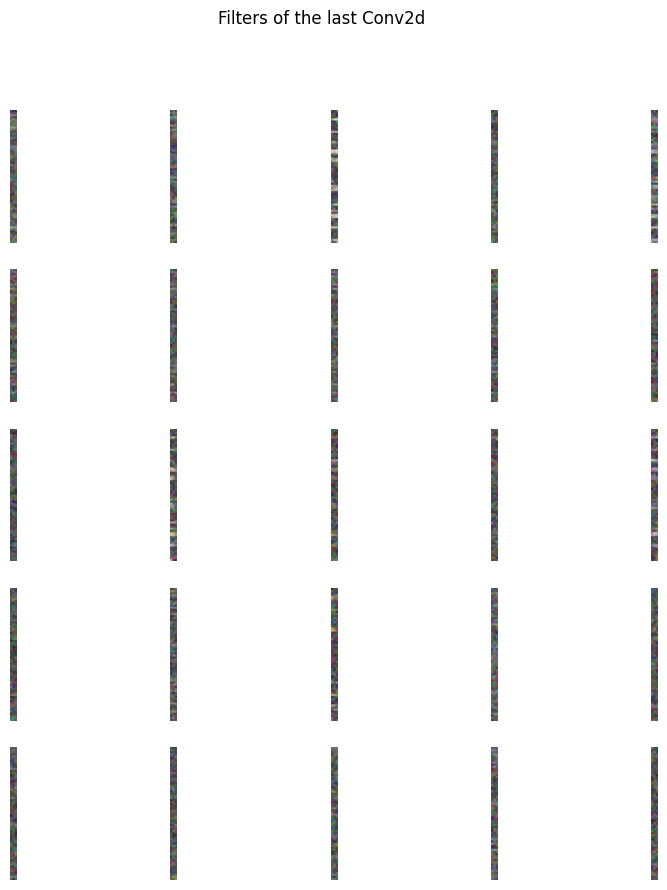

84/84 [==============================] - 5s 24ms/step - loss: 22.6015 - accuracy: 0.4989 - auc_1: 0.5037 - precision_1: 0.4989 - recall_1: 0.4989 - val_loss: 0.6660 - val_accuracy: 0.6111 - val_auc_1: 0.6499 - val_precision_1: 0.6111 - val_recall_1: 0.6111
Epoch 2/100
81/84 [===========================>..] - ETA: 0s - loss: 0.6547 - accuracy: 0.6504 - auc_1: 0.6972 - precision_1: 0.6504 - recall_1: 0.6504

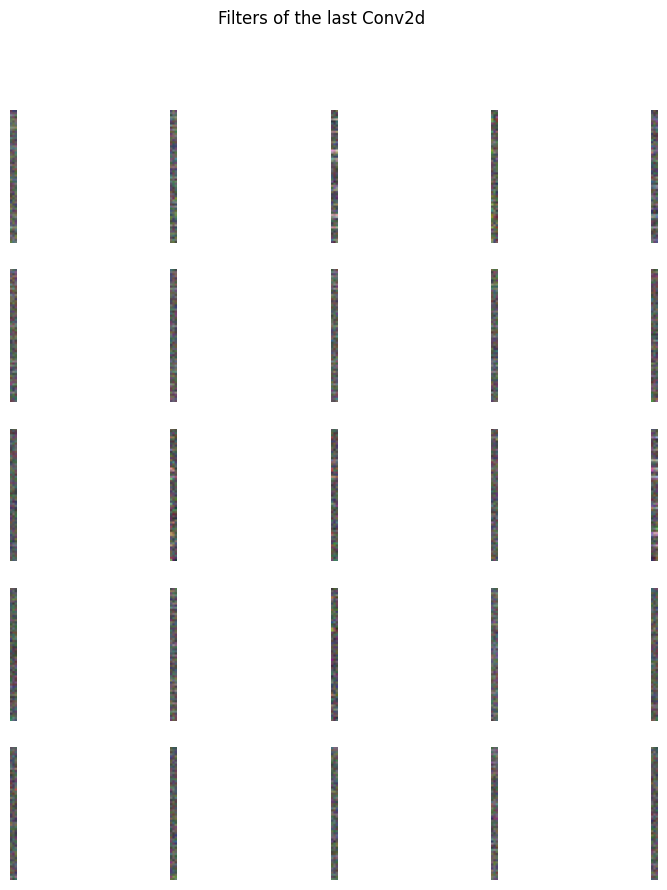

84/84 [==============================] - 2s 18ms/step - loss: 0.6553 - accuracy: 0.6424 - auc_1: 0.6893 - precision_1: 0.6424 - recall_1: 0.6424 - val_loss: 0.6705 - val_accuracy: 0.5764 - val_auc_1: 0.5992 - val_precision_1: 0.5764 - val_recall_1: 0.5764
Epoch 3/100
82/84 [============================>.] - ETA: 0s - loss: 0.6745 - accuracy: 0.5366 - auc_1: 0.5408 - precision_1: 0.5366 - recall_1: 0.5366 

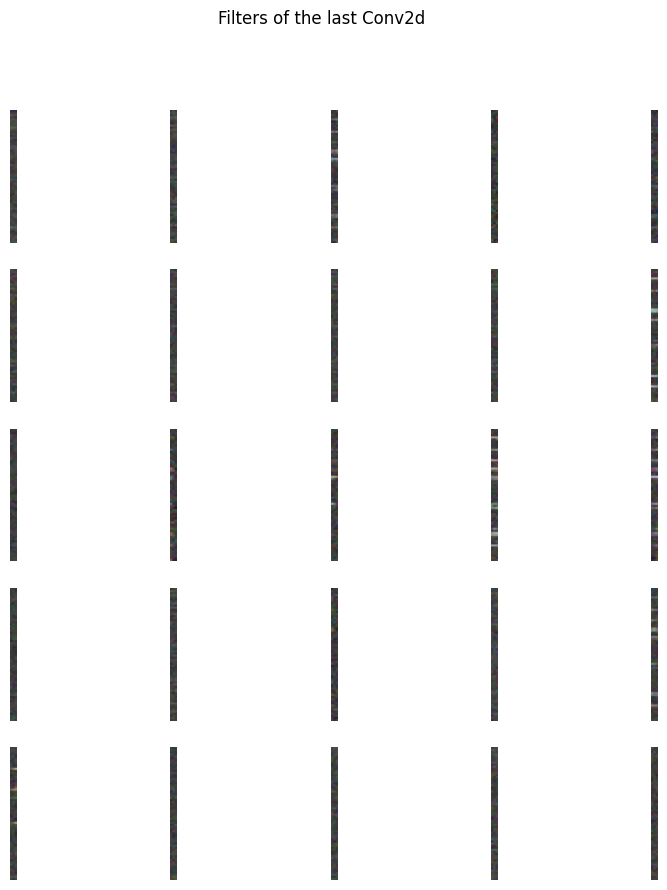

84/84 [==============================] - 2s 18ms/step - loss: 0.6772 - accuracy: 0.5237 - auc_1: 0.5277 - precision_1: 0.5237 - recall_1: 0.5237 - val_loss: 0.6334 - val_accuracy: 0.4896 - val_auc_1: 0.5605 - val_precision_1: 0.4896 - val_recall_1: 0.4896
Epoch 4/100
80/84 [===========================>..] - ETA: 0s - loss: 0.6466 - accuracy: 0.6022 - auc_1: 0.6532 - precision_1: 0.6022 - recall_1: 0.6022

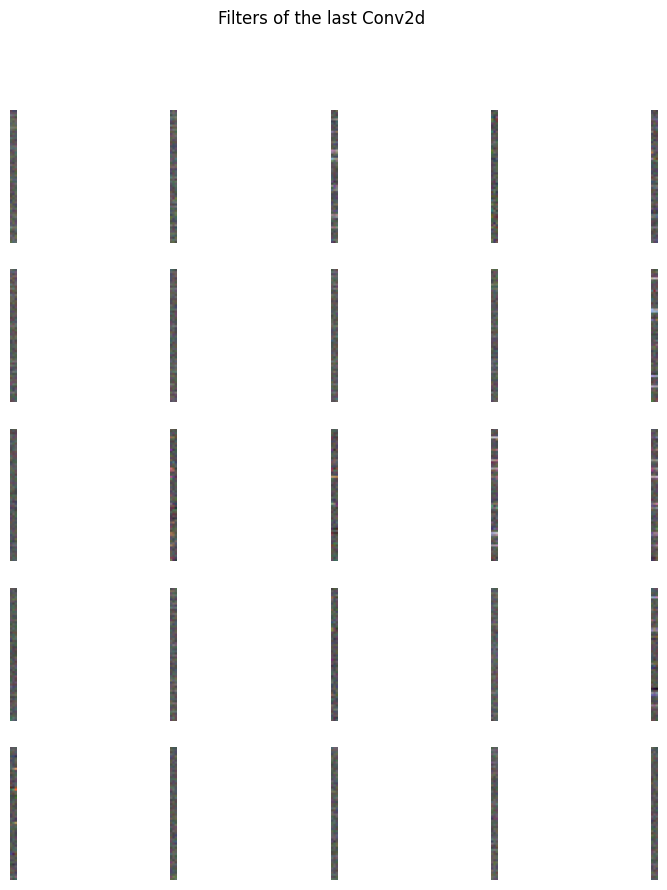

84/84 [==============================] - 2s 21ms/step - loss: 0.6443 - accuracy: 0.6093 - auc_1: 0.6634 - precision_1: 0.6093 - recall_1: 0.6093 - val_loss: 0.6120 - val_accuracy: 0.6319 - val_auc_1: 0.6828 - val_precision_1: 0.6319 - val_recall_1: 0.6319
Epoch 5/100
82/84 [============================>.] - ETA: 0s - loss: 0.5392 - accuracy: 0.7360 - auc_1: 0.7781 - precision_1: 0.7360 - recall_1: 0.7360

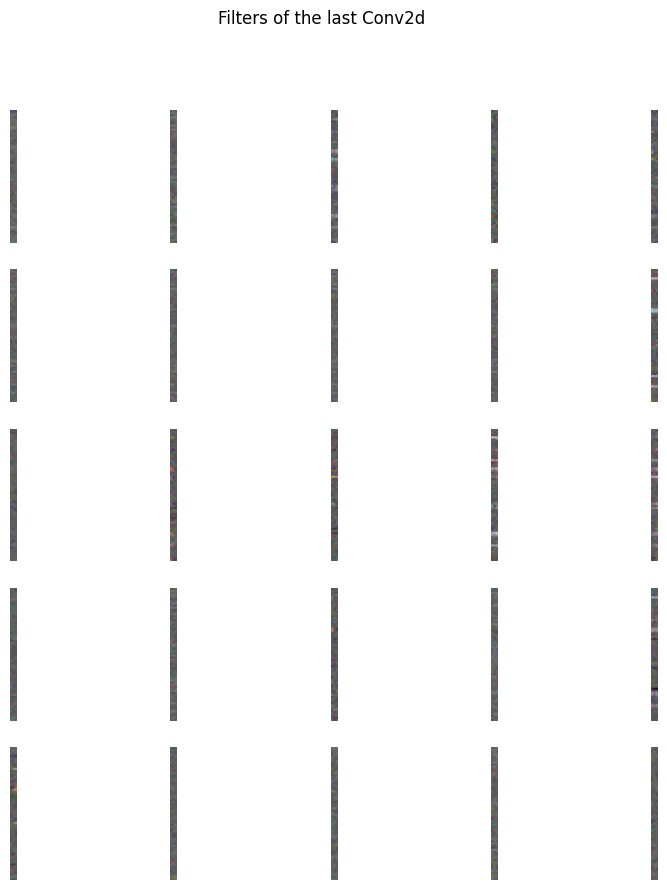

84/84 [==============================] - 2s 18ms/step - loss: 0.5386 - accuracy: 0.7303 - auc_1: 0.7738 - precision_1: 0.7303 - recall_1: 0.7303 - val_loss: 0.4778 - val_accuracy: 0.7865 - val_auc_1: 0.8469 - val_precision_1: 0.7865 - val_recall_1: 0.7865
Epoch 6/100
81/84 [===========================>..] - ETA: 0s - loss: 0.3999 - accuracy: 0.8531 - auc_1: 0.9177 - precision_1: 0.8531 - recall_1: 0.8531

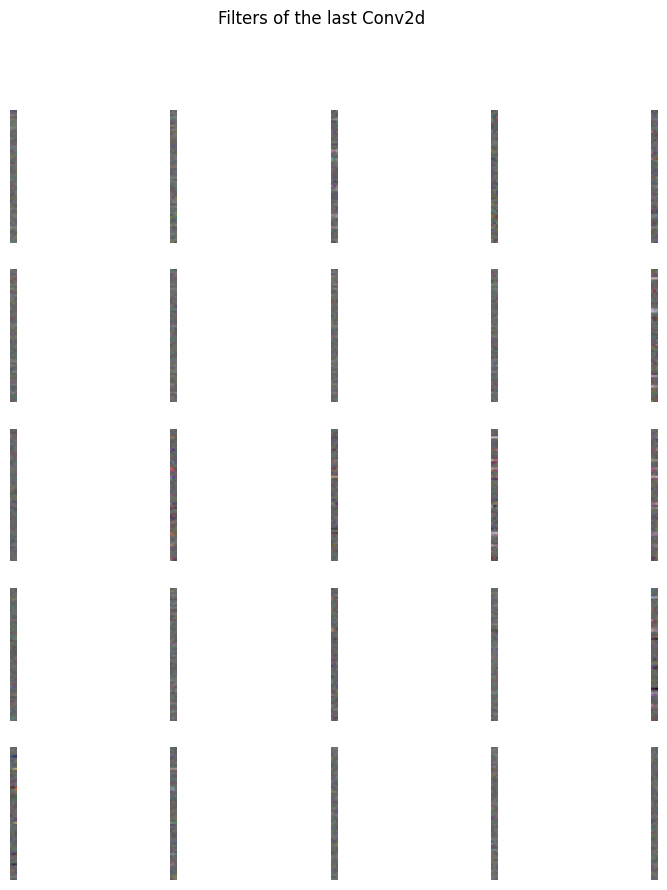

84/84 [==============================] - 2s 21ms/step - loss: 0.3958 - accuracy: 0.8580 - auc_1: 0.9222 - precision_1: 0.8580 - recall_1: 0.8580 - val_loss: 0.6452 - val_accuracy: 0.6910 - val_auc_1: 0.7653 - val_precision_1: 0.6910 - val_recall_1: 0.6910
Epoch 7/100
84/84 [==============================] - ETA: 0s - loss: 0.5422 - accuracy: 0.7607 - auc_1: 0.8210 - precision_1: 0.7607 - recall_1: 0.7607

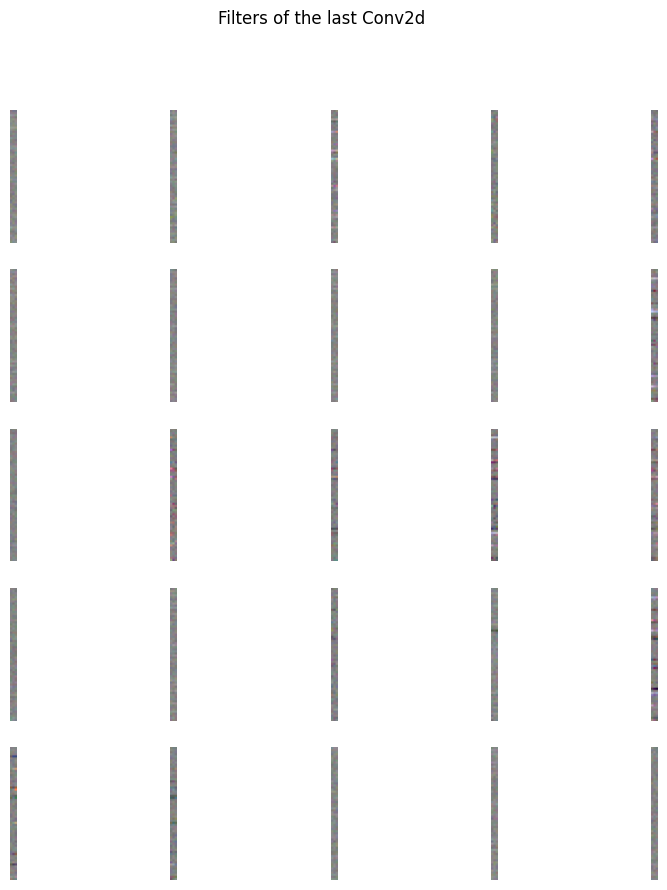

84/84 [==============================] - 2s 19ms/step - loss: 0.5422 - accuracy: 0.7607 - auc_1: 0.8210 - precision_1: 0.7607 - recall_1: 0.7607 - val_loss: 0.5208 - val_accuracy: 0.7378 - val_auc_1: 0.8064 - val_precision_1: 0.7378 - val_recall_1: 0.7378
Epoch 8/100
82/84 [============================>.] - ETA: 0s - loss: 0.3505 - accuracy: 0.8992 - auc_1: 0.9497 - precision_1: 0.8992 - recall_1: 0.8992

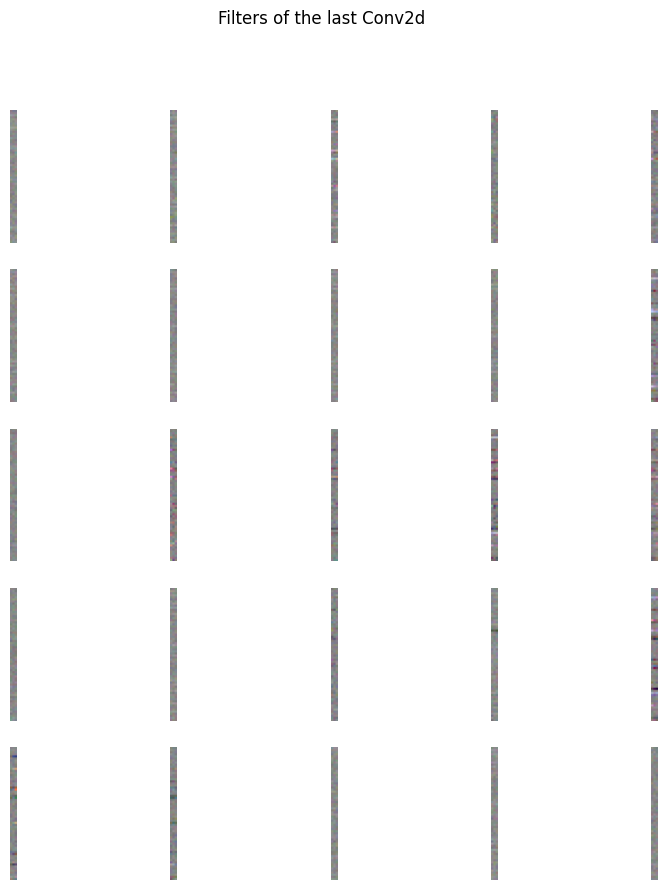

84/84 [==============================] - 2s 21ms/step - loss: 0.3487 - accuracy: 0.9012 - auc_1: 0.9511 - precision_1: 0.9012 - recall_1: 0.9012 - val_loss: 0.2532 - val_accuracy: 0.9045 - val_auc_1: 0.9630 - val_precision_1: 0.9045 - val_recall_1: 0.9045
Epoch 9/100
80/84 [===========================>..] - ETA: 0s - loss: 0.1984 - accuracy: 0.9345 - auc_1: 0.9724 - precision_1: 0.9345 - recall_1: 0.9345

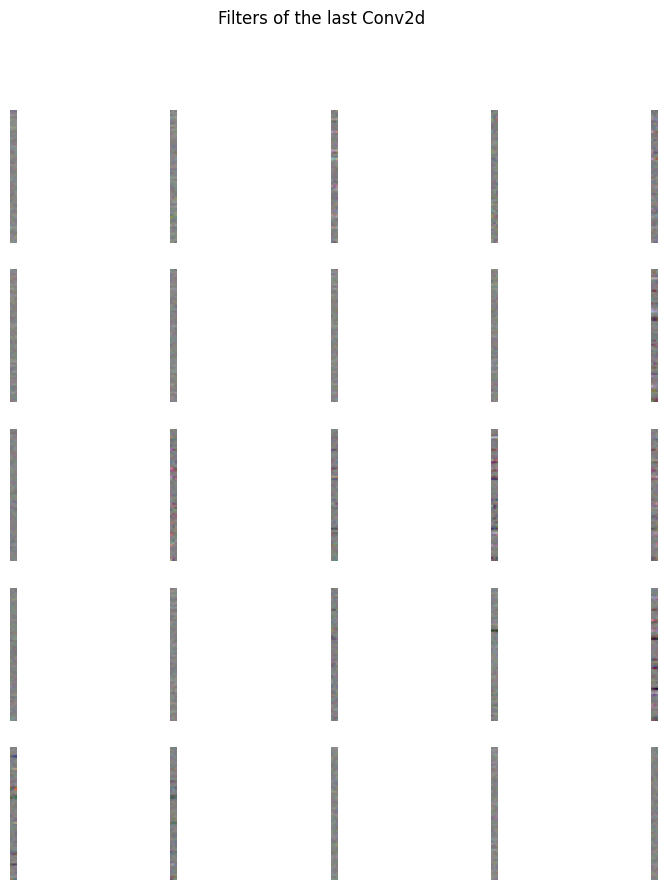

84/84 [==============================] - 2s 19ms/step - loss: 0.1929 - accuracy: 0.9358 - auc_1: 0.9740 - precision_1: 0.9358 - recall_1: 0.9358 - val_loss: 0.1970 - val_accuracy: 0.9184 - val_auc_1: 0.9793 - val_precision_1: 0.9184 - val_recall_1: 0.9184
Epoch 10/100
82/84 [============================>.] - ETA: 0s - loss: 0.1439 - accuracy: 0.9592 - auc_1: 0.9856 - precision_1: 0.9592 - recall_1: 0.9592

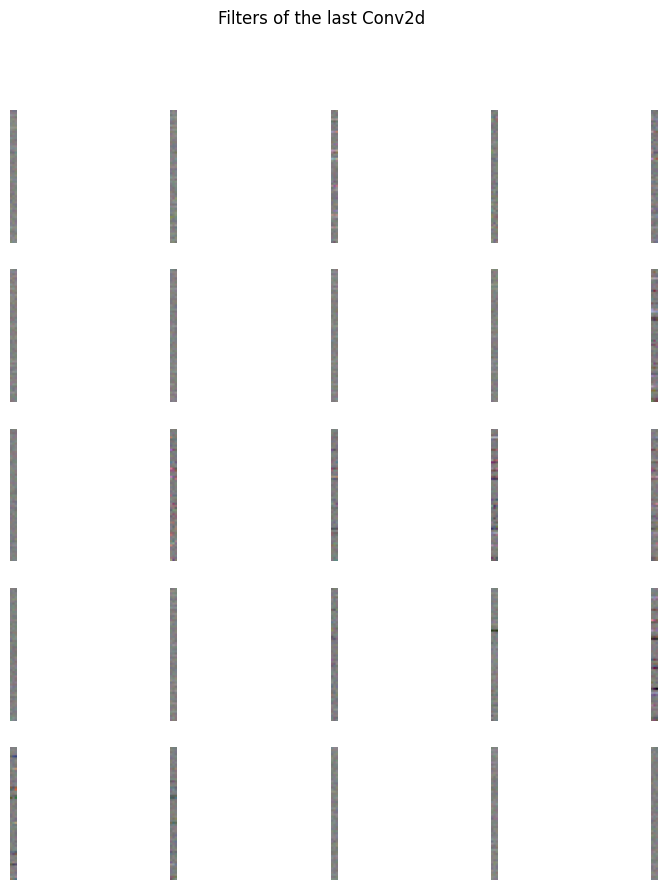

84/84 [==============================] - 2s 18ms/step - loss: 0.1406 - accuracy: 0.9602 - auc_1: 0.9863 - precision_1: 0.9602 - recall_1: 0.9602 - val_loss: 0.0871 - val_accuracy: 0.9757 - val_auc_1: 0.9952 - val_precision_1: 0.9757 - val_recall_1: 0.9757
Epoch 11/100
81/84 [===========================>..] - ETA: 0s - loss: 0.4032 - accuracy: 0.8753 - auc_1: 0.9154 - precision_1: 0.8753 - recall_1: 0.8753

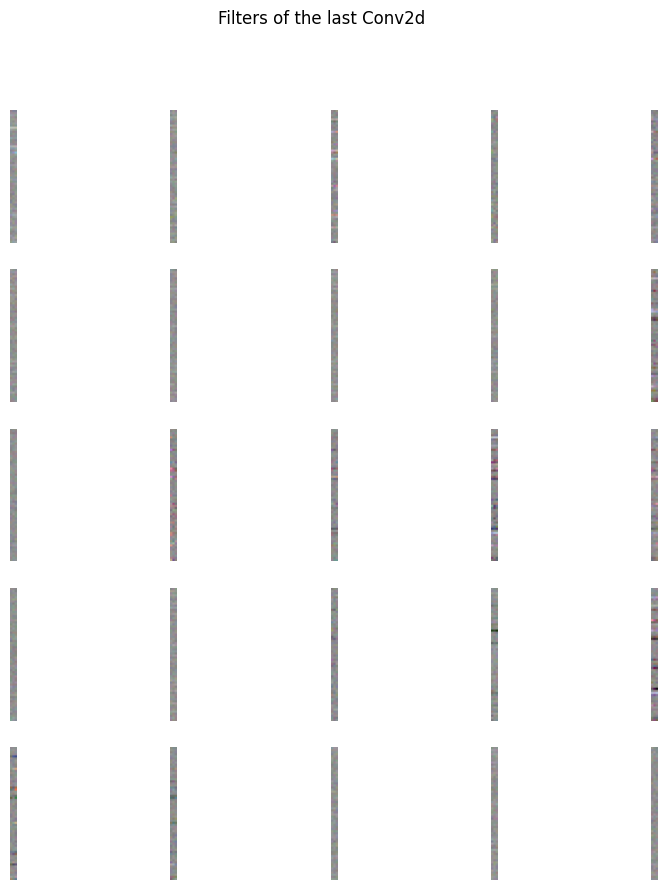

84/84 [==============================] - 2s 21ms/step - loss: 0.3971 - accuracy: 0.8775 - auc_1: 0.9160 - precision_1: 0.8775 - recall_1: 0.8775 - val_loss: 0.3207 - val_accuracy: 0.8767 - val_auc_1: 0.9376 - val_precision_1: 0.8767 - val_recall_1: 0.8767
Epoch 12/100
81/84 [===========================>..] - ETA: 0s - loss: 0.2601 - accuracy: 0.9369 - auc_1: 0.9695 - precision_1: 0.9369 - recall_1: 0.9369

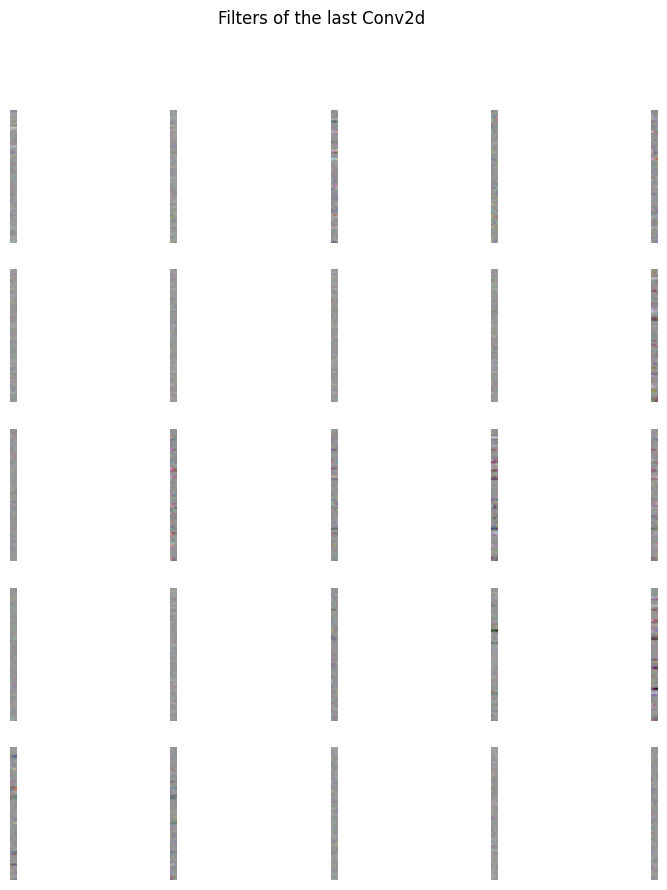

84/84 [==============================] - 2s 18ms/step - loss: 0.2540 - accuracy: 0.9384 - auc_1: 0.9704 - precision_1: 0.9384 - recall_1: 0.9384 - val_loss: 0.2383 - val_accuracy: 0.9115 - val_auc_1: 0.9681 - val_precision_1: 0.9115 - val_recall_1: 0.9115
Epoch 13/100
82/84 [============================>.] - ETA: 0s - loss: 0.1721 - accuracy: 0.9411 - auc_1: 0.9794 - precision_1: 0.9411 - recall_1: 0.9411

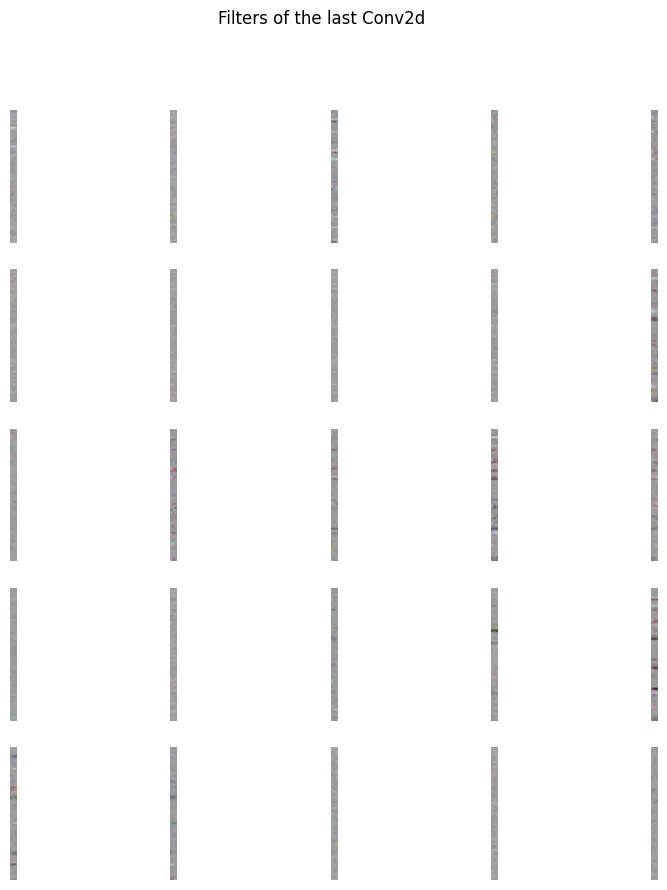

84/84 [==============================] - 2s 21ms/step - loss: 0.1682 - accuracy: 0.9425 - auc_1: 0.9803 - precision_1: 0.9425 - recall_1: 0.9425 - val_loss: 0.0654 - val_accuracy: 0.9826 - val_auc_1: 0.9963 - val_precision_1: 0.9826 - val_recall_1: 0.9826
Epoch 14/100
82/84 [============================>.] - ETA: 0s - loss: 0.0679 - accuracy: 0.9819 - auc_1: 0.9953 - precision_1: 0.9819 - recall_1: 0.9819

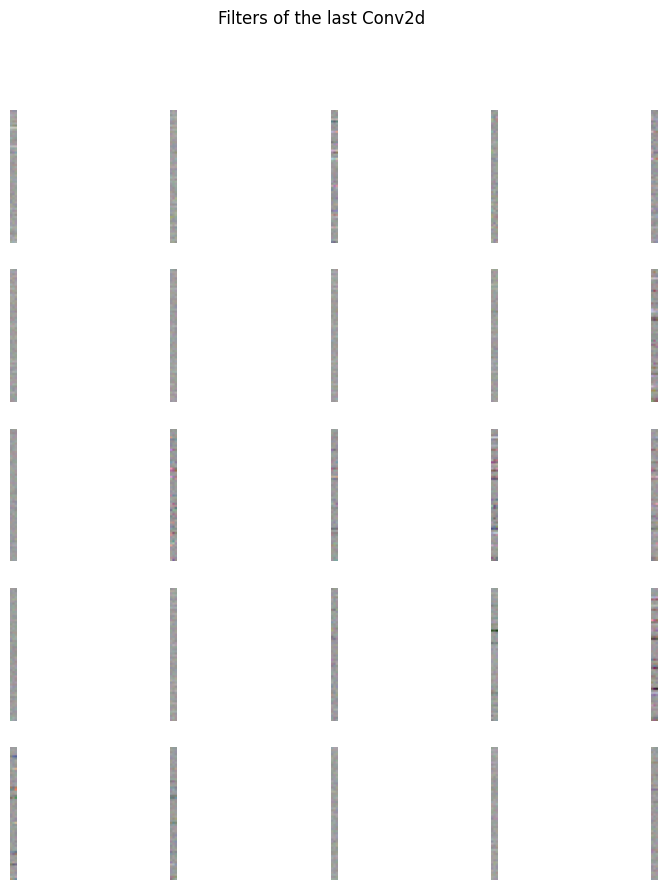

84/84 [==============================] - 1s 18ms/step - loss: 0.0685 - accuracy: 0.9816 - auc_1: 0.9954 - precision_1: 0.9816 - recall_1: 0.9816 - val_loss: 0.0647 - val_accuracy: 0.9861 - val_auc_1: 0.9952 - val_precision_1: 0.9861 - val_recall_1: 0.9861
Epoch 15/100
82/84 [============================>.] - ETA: 0s - loss: 0.0760 - accuracy: 0.9808 - auc_1: 0.9948 - precision_1: 0.9808 - recall_1: 0.9808

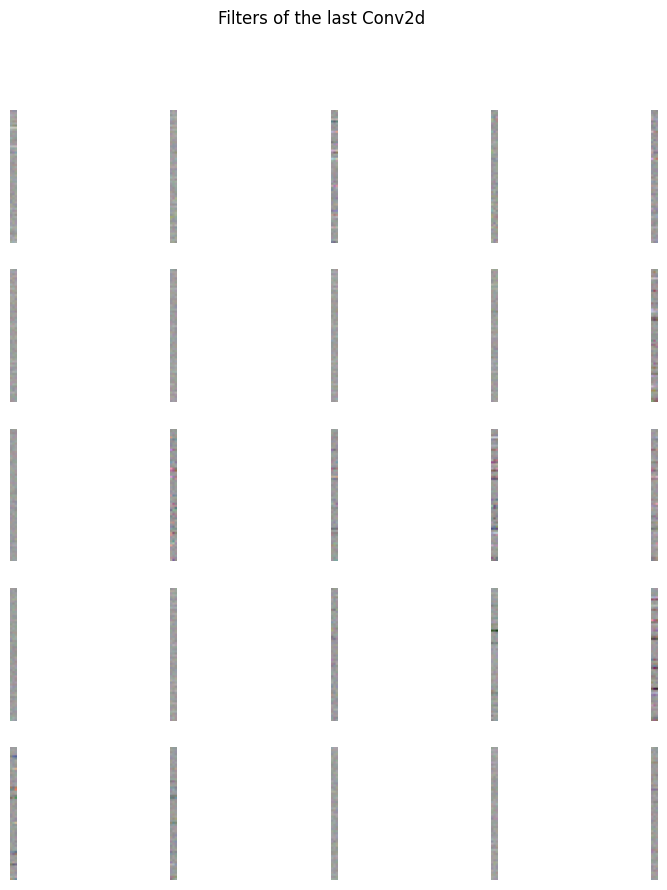

84/84 [==============================] - 1s 18ms/step - loss: 0.0749 - accuracy: 0.9812 - auc_1: 0.9949 - precision_1: 0.9812 - recall_1: 0.9812 - val_loss: 0.0458 - val_accuracy: 0.9844 - val_auc_1: 0.9990 - val_precision_1: 0.9844 - val_recall_1: 0.9844
Epoch 16/100
82/84 [============================>.] - ETA: 0s - loss: 0.0460 - accuracy: 0.9854 - auc_1: 0.9977 - precision_1: 0.9854 - recall_1: 0.9854

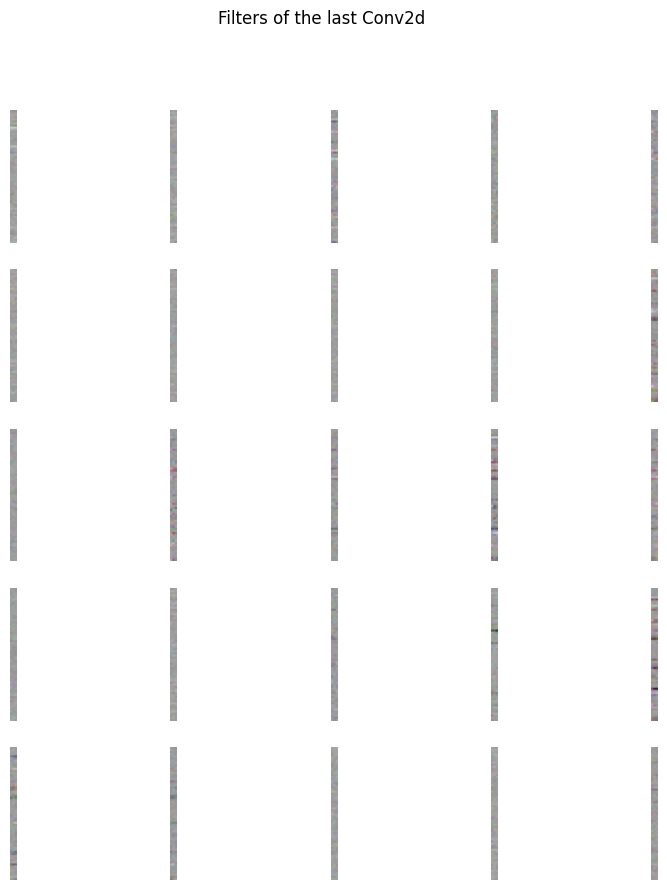

84/84 [==============================] - 2s 21ms/step - loss: 0.0450 - accuracy: 0.9857 - auc_1: 0.9977 - precision_1: 0.9857 - recall_1: 0.9857 - val_loss: 0.0947 - val_accuracy: 0.9670 - val_auc_1: 0.9953 - val_precision_1: 0.9670 - val_recall_1: 0.9670
Epoch 17/100
82/84 [============================>.] - ETA: 0s - loss: 0.0710 - accuracy: 0.9784 - auc_1: 0.9951 - precision_1: 0.9784 - recall_1: 0.9784

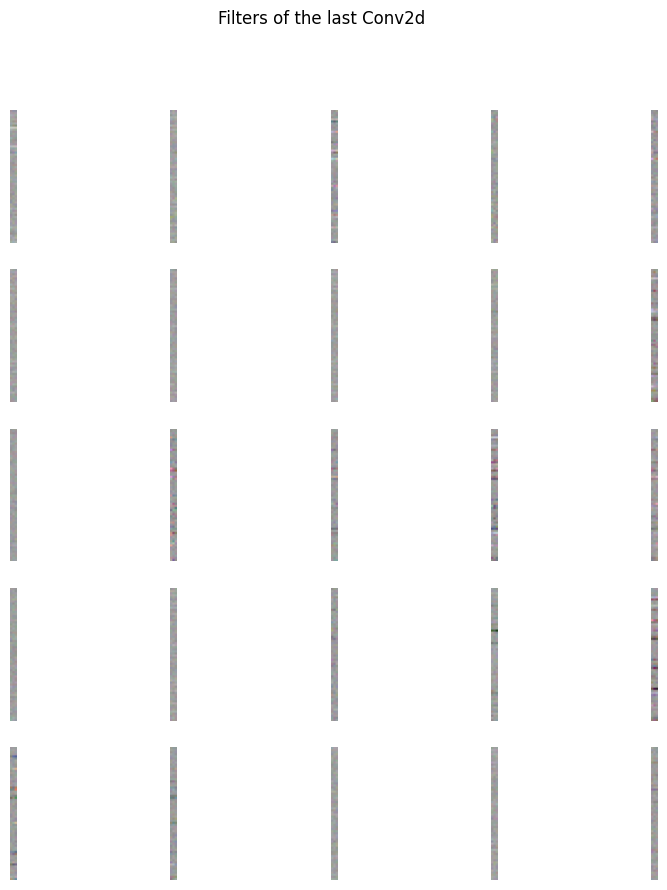

84/84 [==============================] - 2s 18ms/step - loss: 0.0727 - accuracy: 0.9775 - auc_1: 0.9951 - precision_1: 0.9775 - recall_1: 0.9775 - val_loss: 0.0515 - val_accuracy: 0.9878 - val_auc_1: 0.9970 - val_precision_1: 0.9878 - val_recall_1: 0.9878
Epoch 18/100
82/84 [============================>.] - ETA: 0s - loss: 0.0388 - accuracy: 0.9885 - auc_1: 0.9984 - precision_1: 0.9885 - recall_1: 0.9885

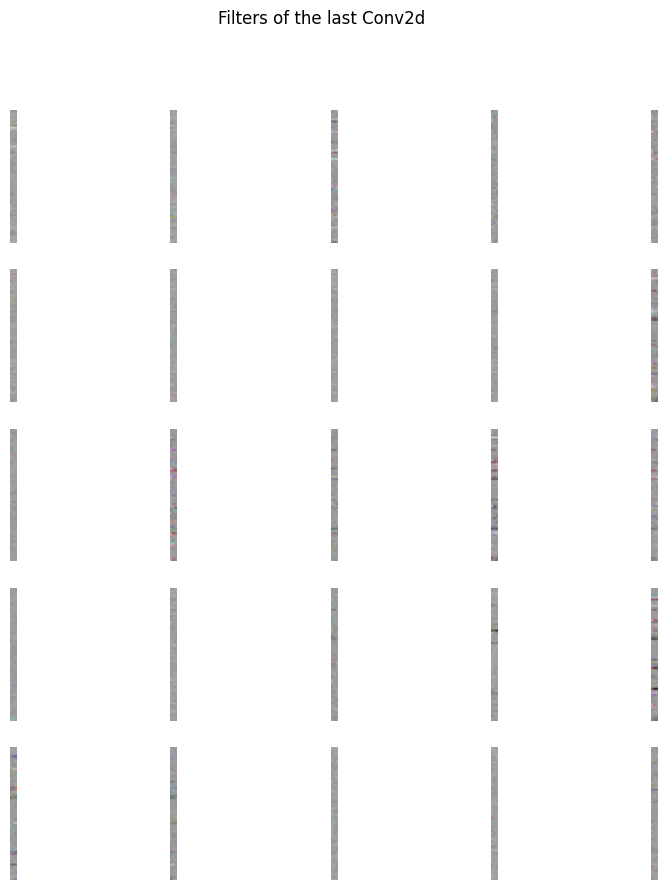

84/84 [==============================] - 2s 20ms/step - loss: 0.0379 - accuracy: 0.9887 - auc_1: 0.9984 - precision_1: 0.9887 - recall_1: 0.9887 - val_loss: 0.0245 - val_accuracy: 0.9896 - val_auc_1: 0.9998 - val_precision_1: 0.9896 - val_recall_1: 0.9896
Epoch 19/100
82/84 [============================>.] - ETA: 0s - loss: 0.0699 - accuracy: 0.9788 - auc_1: 0.9958 - precision_1: 0.9788 - recall_1: 0.9788

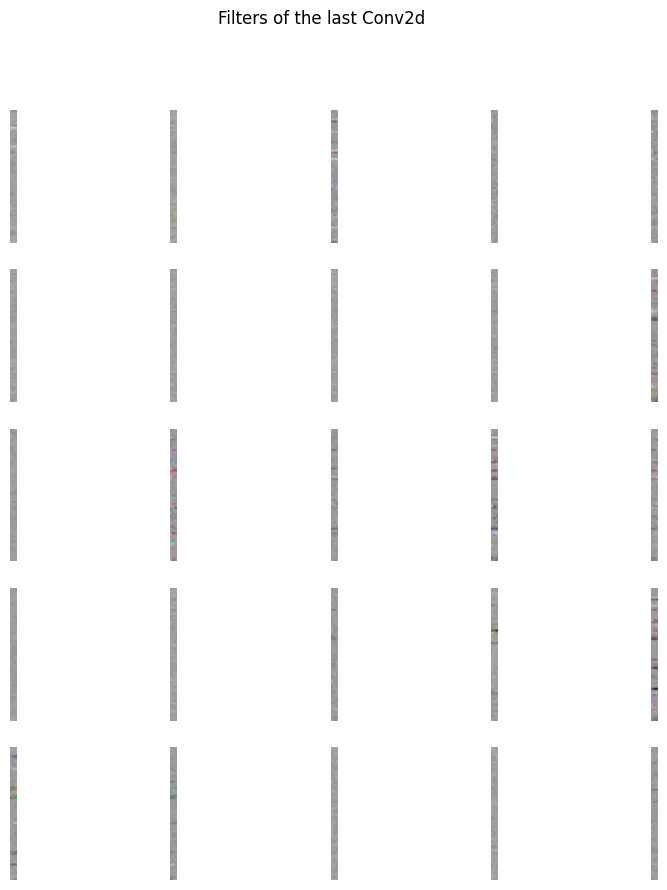

84/84 [==============================] - 2s 18ms/step - loss: 0.0701 - accuracy: 0.9782 - auc_1: 0.9958 - precision_1: 0.9782 - recall_1: 0.9782 - val_loss: 0.0359 - val_accuracy: 0.9844 - val_auc_1: 0.9995 - val_precision_1: 0.9844 - val_recall_1: 0.9844
Epoch 20/100
81/84 [===========================>..] - ETA: 0s - loss: 0.0418 - accuracy: 0.9875 - auc_1: 0.9983 - precision_1: 0.9875 - recall_1: 0.9875

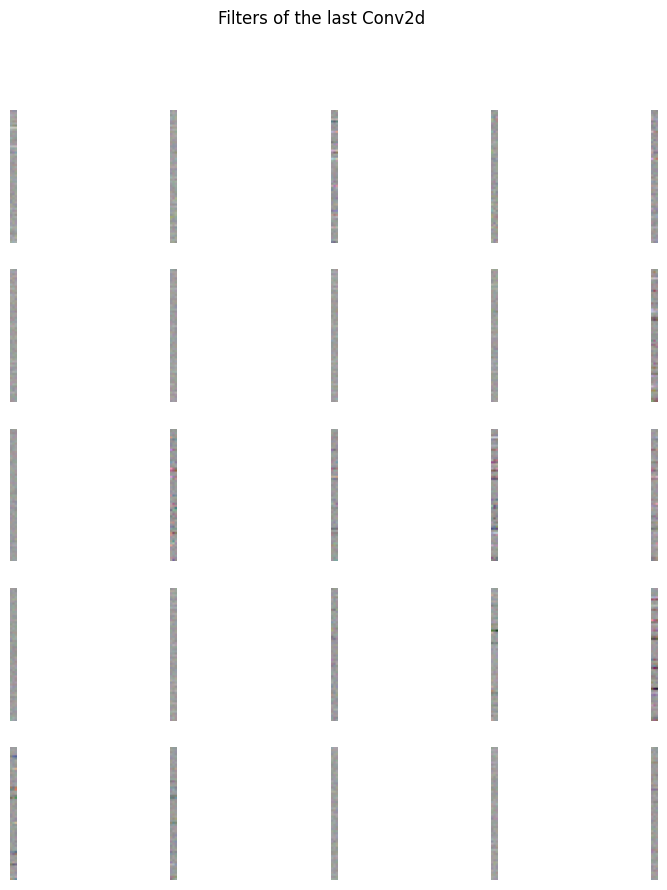

84/84 [==============================] - 2s 18ms/step - loss: 0.0404 - accuracy: 0.9880 - auc_1: 0.9984 - precision_1: 0.9880 - recall_1: 0.9880 - val_loss: 0.0234 - val_accuracy: 0.9896 - val_auc_1: 0.9998 - val_precision_1: 0.9896 - val_recall_1: 0.9896
Epoch 21/100
82/84 [============================>.] - ETA: 0s - loss: 0.0244 - accuracy: 0.9908 - auc_1: 0.9996 - precision_1: 0.9908 - recall_1: 0.9908

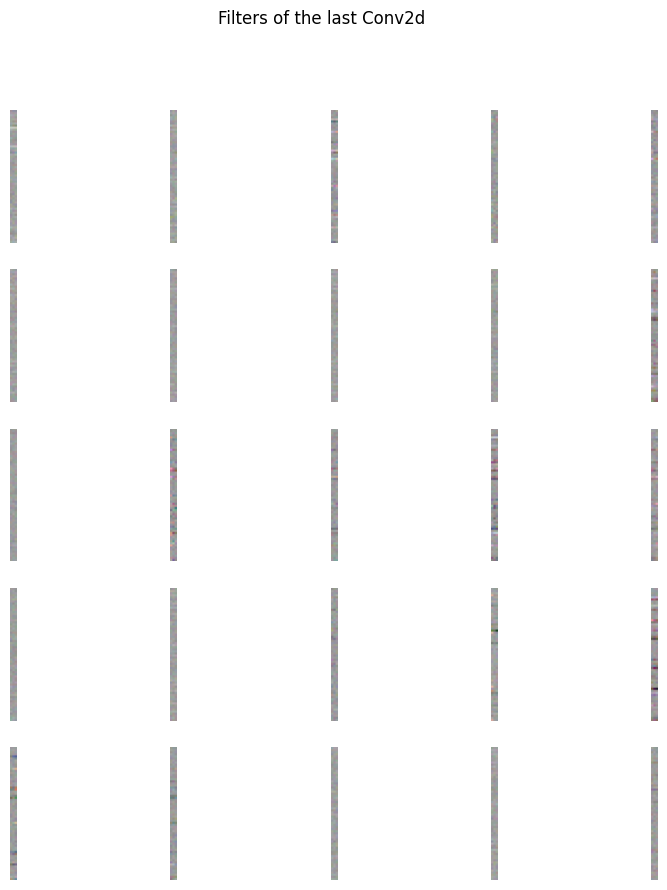

84/84 [==============================] - 2s 21ms/step - loss: 0.0240 - accuracy: 0.9910 - auc_1: 0.9996 - precision_1: 0.9910 - recall_1: 0.9910 - val_loss: 0.0217 - val_accuracy: 0.9913 - val_auc_1: 0.9998 - val_precision_1: 0.9913 - val_recall_1: 0.9913
Epoch 22/100
81/84 [===========================>..] - ETA: 0s - loss: 1.5157 - accuracy: 0.9236 - auc_1: 0.9405 - precision_1: 0.9236 - recall_1: 0.9236

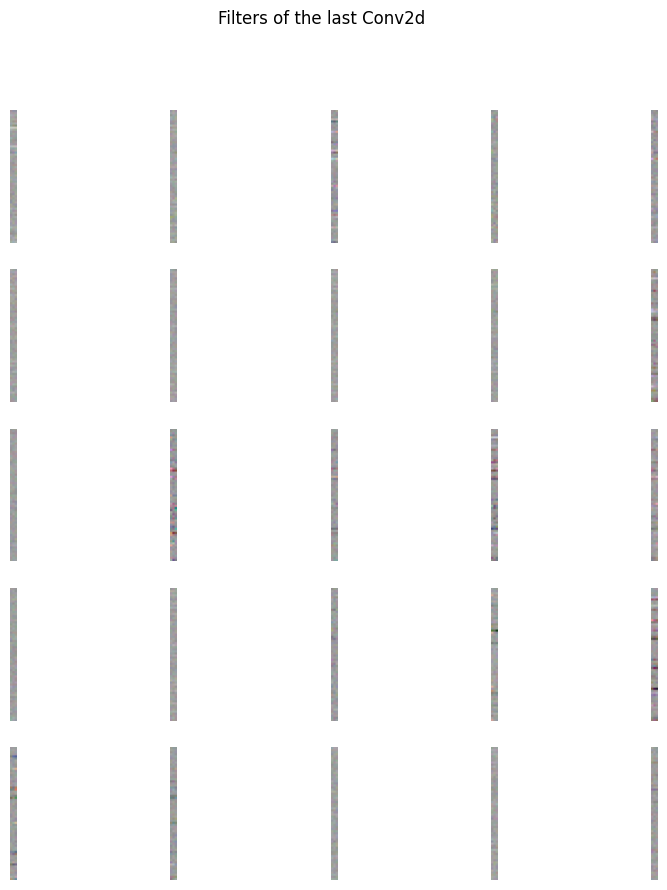

84/84 [==============================] - 2s 18ms/step - loss: 1.4962 - accuracy: 0.9144 - auc_1: 0.9393 - precision_1: 0.9144 - recall_1: 0.9144 - val_loss: 1.2141 - val_accuracy: 0.5104 - val_auc_1: 0.5104 - val_precision_1: 0.5104 - val_recall_1: 0.5104
Epoch 23/100
82/84 [============================>.] - ETA: 0s - loss: 0.7435 - accuracy: 0.4842 - auc_1: 0.4805 - precision_1: 0.4842 - recall_1: 0.4842

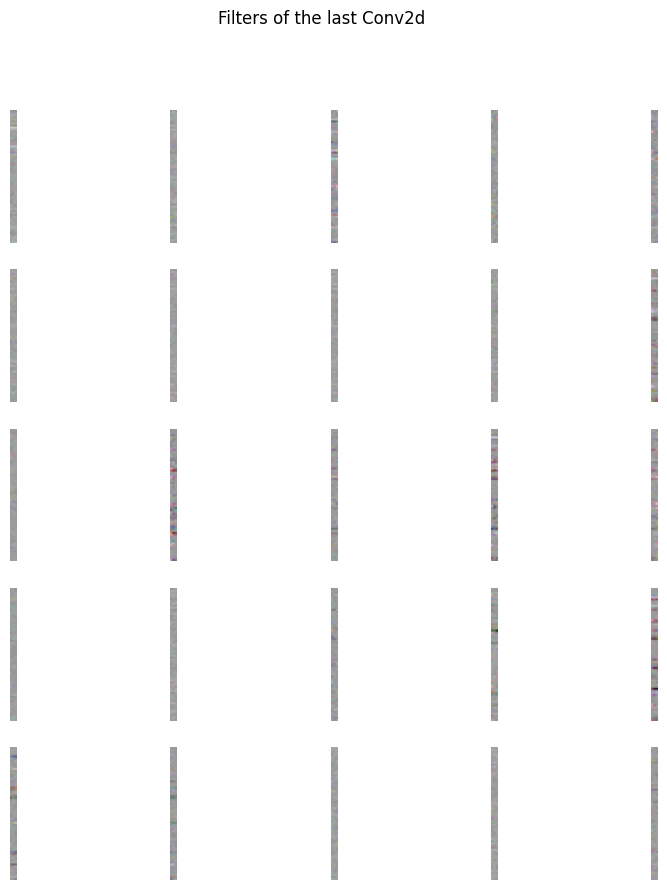

84/84 [==============================] - 2s 20ms/step - loss: 0.7444 - accuracy: 0.4726 - auc_1: 0.4760 - precision_1: 0.4726 - recall_1: 0.4726 - val_loss: 0.6942 - val_accuracy: 0.5104 - val_auc_1: 0.5095 - val_precision_1: 0.5104 - val_recall_1: 0.5104
Epoch 24/100
80/84 [===========================>..] - ETA: 0s - loss: 0.7066 - accuracy: 0.5122 - auc_1: 0.4707 - precision_1: 0.5122 - recall_1: 0.5122

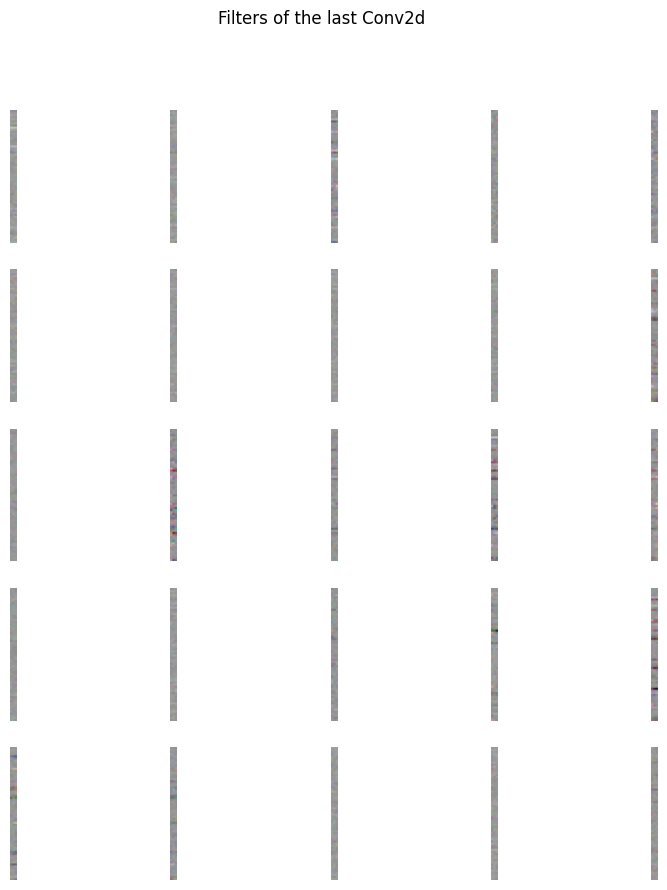

84/84 [==============================] - 2s 18ms/step - loss: 0.7061 - accuracy: 0.5116 - auc_1: 0.4719 - precision_1: 0.5116 - recall_1: 0.5116 - val_loss: 0.6960 - val_accuracy: 0.5104 - val_auc_1: 0.5131 - val_precision_1: 0.5104 - val_recall_1: 0.5104
Epoch 25/100
82/84 [============================>.] - ETA: 0s - loss: 0.7074 - accuracy: 0.4619 - auc_1: 0.4240 - precision_1: 0.4619 - recall_1: 0.4619 

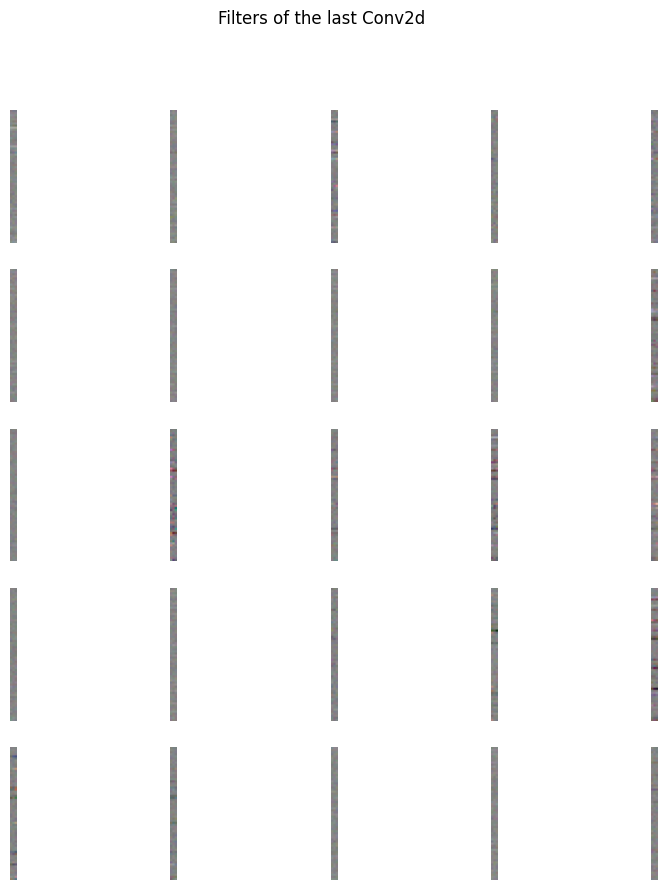

84/84 [==============================] - 2s 21ms/step - loss: 0.7059 - accuracy: 0.4748 - auc_1: 0.4331 - precision_1: 0.4748 - recall_1: 0.4748 - val_loss: 0.6934 - val_accuracy: 0.5139 - val_auc_1: 0.5130 - val_precision_1: 0.5139 - val_recall_1: 0.5139
Epoch 26/100
82/84 [============================>.] - ETA: 0s - loss: 0.6971 - accuracy: 0.5058 - auc_1: 0.4538 - precision_1: 0.5058 - recall_1: 0.5058

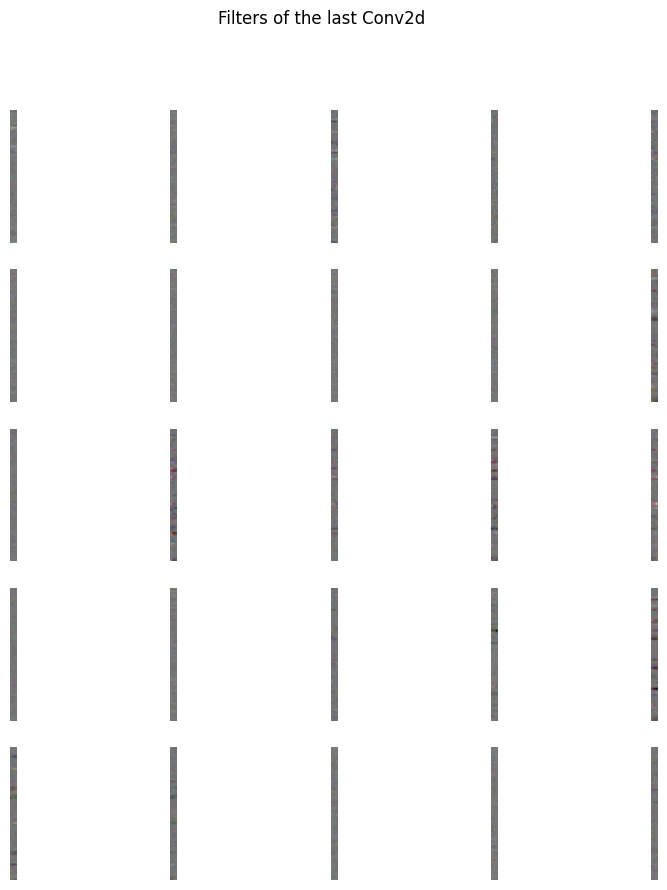

84/84 [==============================] - 2s 18ms/step - loss: 0.6971 - accuracy: 0.4951 - auc_1: 0.4572 - precision_1: 0.4951 - recall_1: 0.4951 - val_loss: 0.6861 - val_accuracy: 0.5365 - val_auc_1: 0.5444 - val_precision_1: 0.5365 - val_recall_1: 0.5365
Epoch 27/100
81/84 [===========================>..] - ETA: 0s - loss: 0.6548 - accuracy: 0.5269 - auc_1: 0.5324 - precision_1: 0.5269 - recall_1: 0.5269

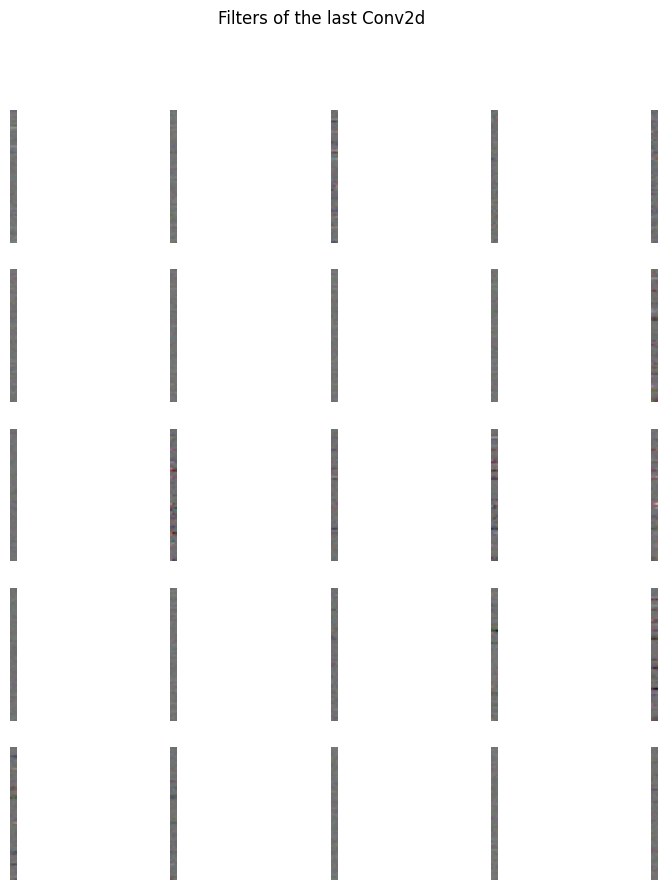

84/84 [==============================] - 2s 18ms/step - loss: 0.6549 - accuracy: 0.5323 - auc_1: 0.5441 - precision_1: 0.5323 - recall_1: 0.5323 - val_loss: 0.6402 - val_accuracy: 0.5920 - val_auc_1: 0.6230 - val_precision_1: 0.5920 - val_recall_1: 0.5920
Epoch 28/100
82/84 [============================>.] - ETA: 0s - loss: 1.0616 - accuracy: 0.6655 - auc_1: 0.6861 - precision_1: 0.6655 - recall_1: 0.6655

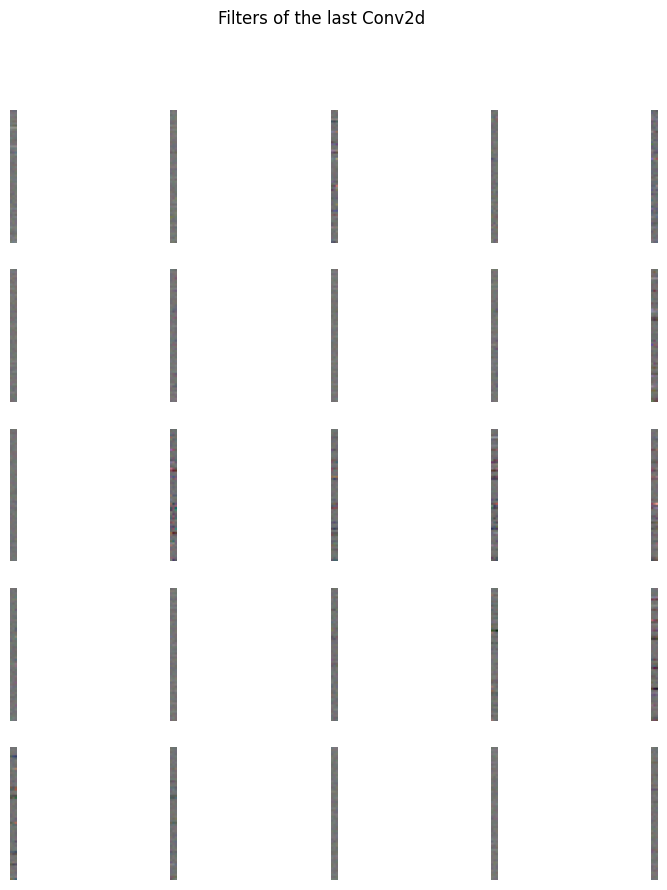

84/84 [==============================] - 2s 21ms/step - loss: 1.0567 - accuracy: 0.6503 - auc_1: 0.6739 - precision_1: 0.6503 - recall_1: 0.6503 - val_loss: 0.6960 - val_accuracy: 0.5226 - val_auc_1: 0.5269 - val_precision_1: 0.5226 - val_recall_1: 0.5226
Epoch 29/100
36/84 [===========>..................] - ETA: 0s - loss: 5.0019 - accuracy: 0.6276 - auc_1: 0.6227 - precision_1: 0.6276 - recall_1: 0.6276

In [ ]:
"""
Train the model
"""
# mkdir for model save path
if not os.path.exists(config.model_dir):
    os.makedirs(config.model_dir)
    
history = model.fit(train_generator,
                    epochs=100,
                    steps_per_epoch=train_num // config.BATCH_SIZE,
                    validation_data=valid_generator,
                    validation_steps=valid_num // config.BATCH_SIZE,
                    callbacks=callbacks)

In [ ]:
# save the whole model
model.save(config.model_dir+config.model_save_name+".h5")

In [ ]:
hist_df = pd.DataFrame(history.history)
with open(config.model_dir+"train_history.csv", mode='w') as f:
    hist_df.to_csv(f)

In [ ]:
# Evaluation
eval_model(model)

In [ ]:
# detect samples
print(config.test_image_path)
test_single_image(config.test_image_path, model)

In [ ]:
import numpy as np
def test_single_image2(img_dir, model):
    img_raw = tf.io.read_file(img_dir)
    img_tensor = tf.image.decode_jpeg(img_raw, channels=config.channels)
    img_tensor = tf.image.resize(img_tensor, [config.image_height, config.image_width])

    img_numpy = img_tensor.numpy()
    img_numpy = (np.expand_dims(img_numpy, 0))
    img_tensor = tf.convert_to_tensor(img_numpy, tf.float32)

    img_tensor = img_tensor / 255.0 # uncomment if model included rescale preprocessing layer
    prob = model(tf.image.resize(img_tensor,[config.image_width,config.image_height]))

    
    
    # 'if not sure go to background' implementation
    precision_threshold = 0.5
    if np.max(prob) < precision_threshold :
        classification = 5
    else :
        classification = np.argmax(prob)
    return classification

In [ ]:
test_single_image2(config.test_image_path, model)